# Homework 04: Building CNNs for Image Classification

## Due: Midnight on February 15 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete all of the graded questions in the homework.


## 1. Setup and Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Testing and training sets already defined, accessed here as global variables

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [3]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model,
                   epochs        = 500,
                   lr_schedule   = 1e-3,
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    cbs = ([early_stop] if use_early_stopping else []) + callbacks

    start = time.time()

    # Fit on tf.data datasets (already batched)
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Determine best validation accuracy
    if use_early_stopping and hasattr(early_stop, "best_epoch") and early_stop.best_epoch is not None:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = int(np.argmax(history.history['val_accuracy']))
        best_acc   = history.history['val_accuracy'][best_epoch]

    plot_learning_curves(history, title=title)

    # Evaluate on tf.data test set
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
import os
import numpy as np
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    n = len(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx = np.concatenate(val_idx_list)

    # Optional: shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file *references* (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        # read bytes -> decode -> resize -> float32 in [0,1]
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        # Disk caching avoids RAM blowups; /tmp is fine in Colab
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Example usage for Intel dataset
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files, train_labels, class_names = list_files_and_labels(train_dir)

num_classes = len(class_names)

# 2) Stratified deterministic split of *indices* (no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 3) Slice file lists
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

# 4) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 5) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)
test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)




### Examine The Dataset

In [6]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 11230 val examples: 2804 test examples: 3000
train per-class counts: {'buildings': 1753, 'forest': 1817, 'glacier': 1924, 'mountain': 2010, 'sea': 1820, 'street': 1906}
val per-class counts: {'buildings': 438, 'forest': 454, 'glacier': 480, 'mountain': 502, 'sea': 454, 'street': 476}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


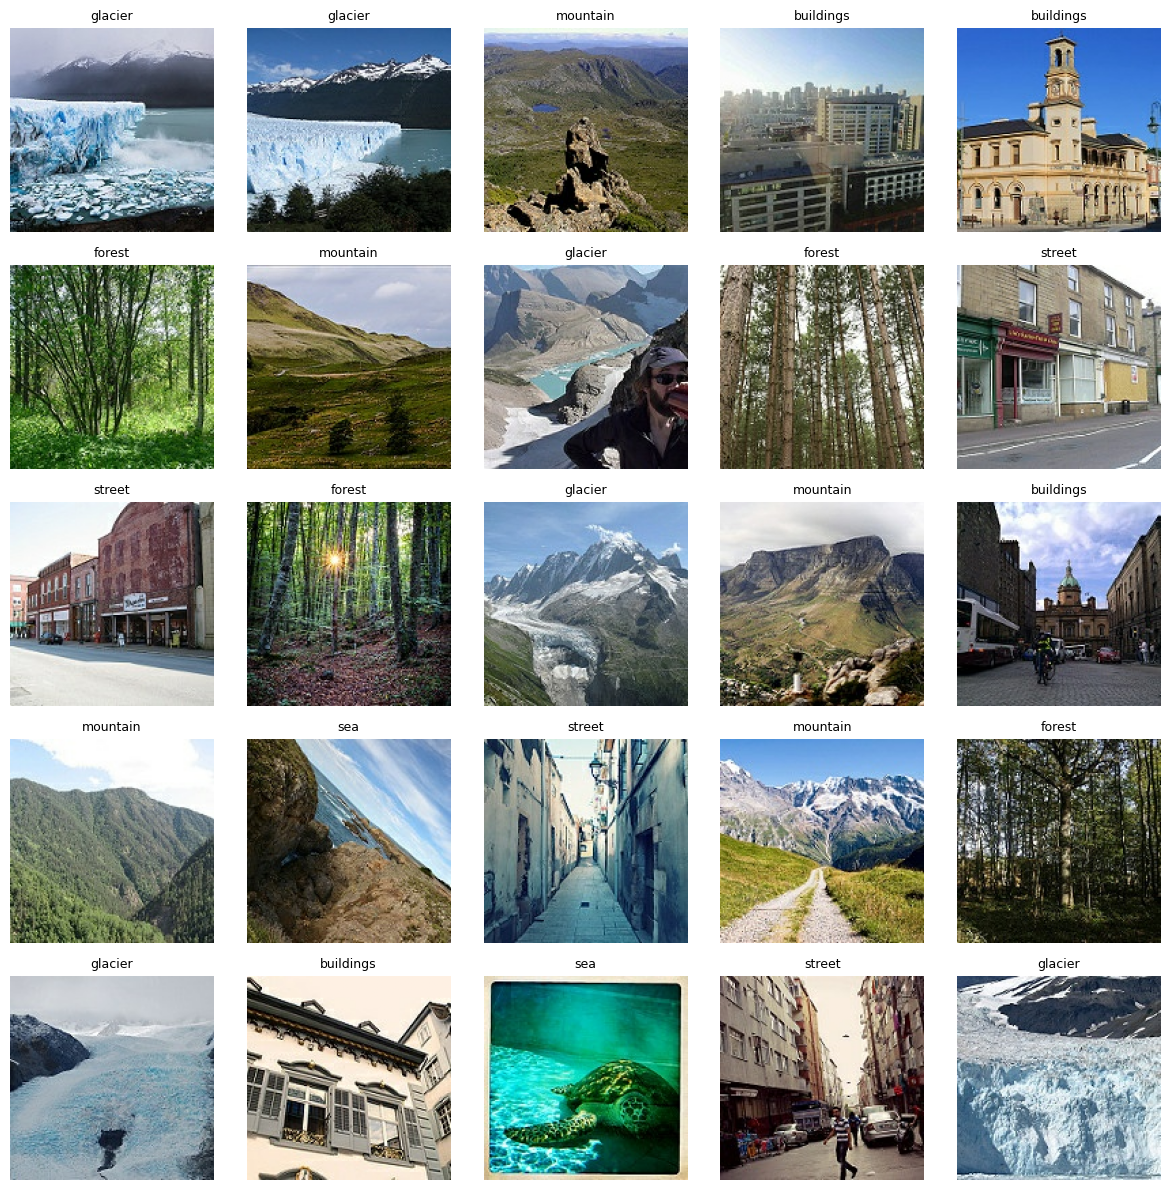

In [7]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.


**Warning:** Sometimes I get this, I think because it has exploding gradients; if you run it again, it generally disappears....

![Screenshot 2025-09-20 at 12.34.00 PM.png](attachment:c750862e-b0c8-405f-ae87-323064e42737.png)


Baseline Model



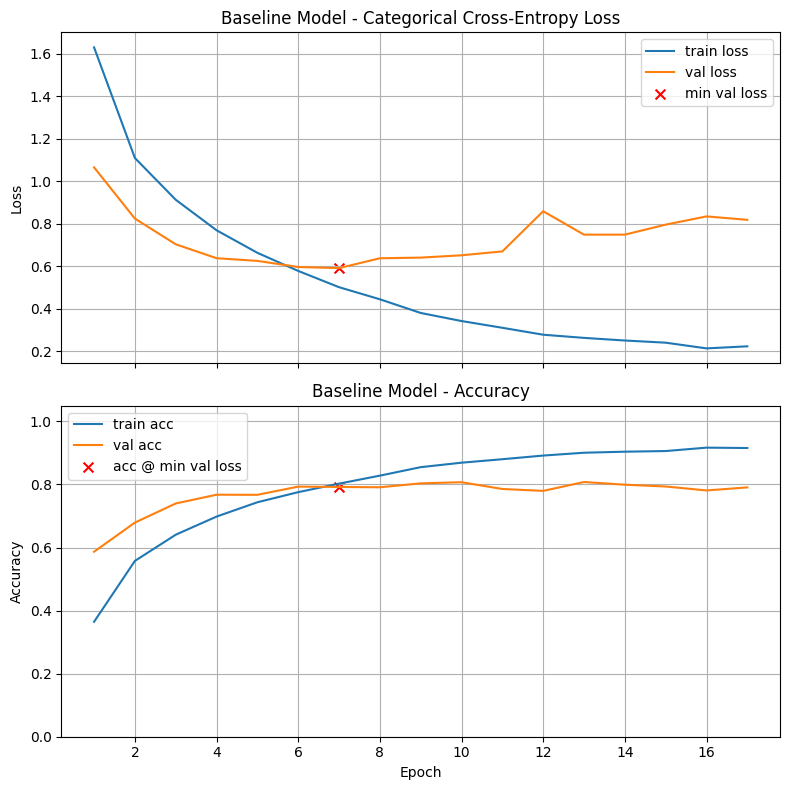

Final Training Loss:            0.2232
Final Training Accuracy:        0.9156
Final Validation Loss:          0.8182
Final Validation Accuracy:      0.7907
Minimum Validation Loss:        0.5911 (Epoch 7)
Validation Accuracy @ Min Loss: 0.7921

Test Loss: 0.6374
Test Accuracy: 0.7873

Validation-Test Gap (accuracy): 0.004749

Execution Time: 00:02:10


In [8]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title=f"Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Problem 1, Tweak 1: lr: 1e-4



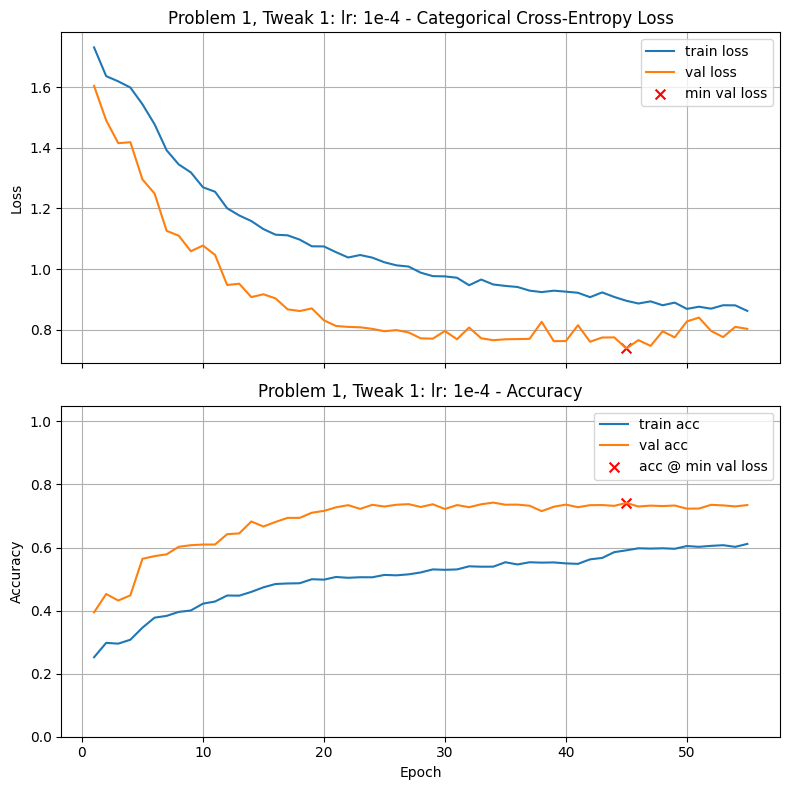

Final Training Loss:            0.8617
Final Training Accuracy:        0.6115
Final Validation Loss:          0.8024
Final Validation Accuracy:      0.7347
Minimum Validation Loss:        0.7380 (Epoch 45)
Validation Accuracy @ Min Loss: 0.7414

Test Loss: 0.7759
Test Accuracy: 0.7320

Validation-Test Gap (accuracy): 0.009441

Execution Time: 00:06:43


In [9]:
# Your code here, add additional cells if you wish
#tweak 1: adjust learning rate
new_lr = 1e-4
he = initializers.HeNormal()                                # best initializer for relu
#build model
base_lr = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
#train and test model
train_and_test(base_lr, lr_schedule = new_lr, title="Problem 1, Tweak 1: lr: 1e-4")



Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128



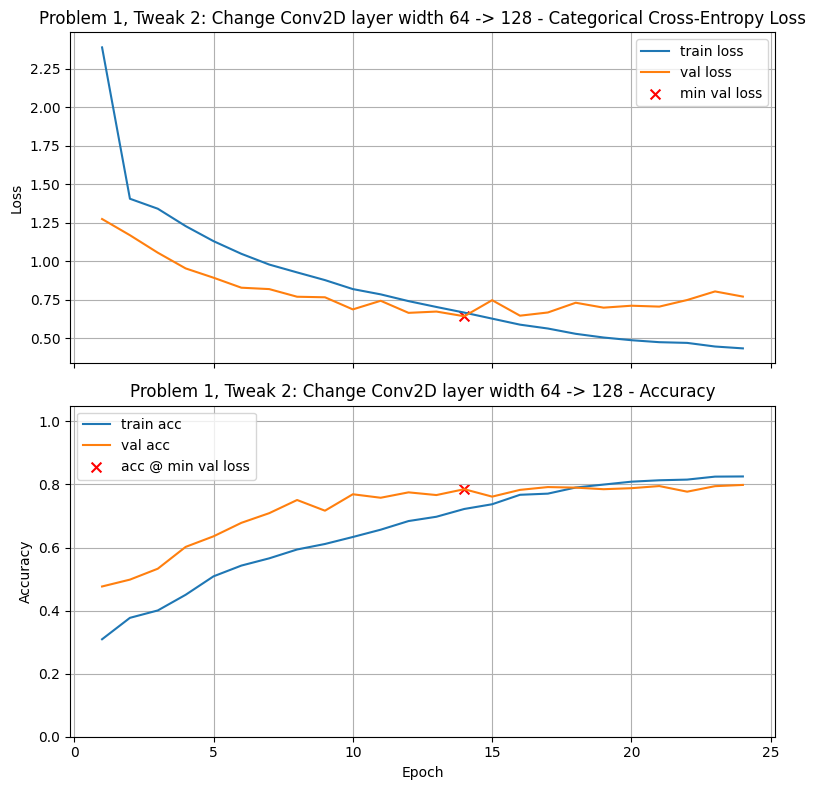

Final Training Loss:            0.4348
Final Training Accuracy:        0.8254
Final Validation Loss:          0.7709
Final Validation Accuracy:      0.7985
Minimum Validation Loss:        0.6433 (Epoch 14)
Validation Accuracy @ Min Loss: 0.7850

Test Loss: 0.7215
Test Accuracy: 0.7793

Validation-Test Gap (accuracy): 0.005617

Execution Time: 00:04:20


In [10]:
#tweak 2: change width of Conv2D layers
#change width 64 to 128
chng = 128
he = initializers.HeNormal()                                # best initializer for relu
#build model
base_wide = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(chng, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
#train and test
train_and_test(base_wide, title="Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128")


Problem 1, Tweak 6: Dropout 0.3



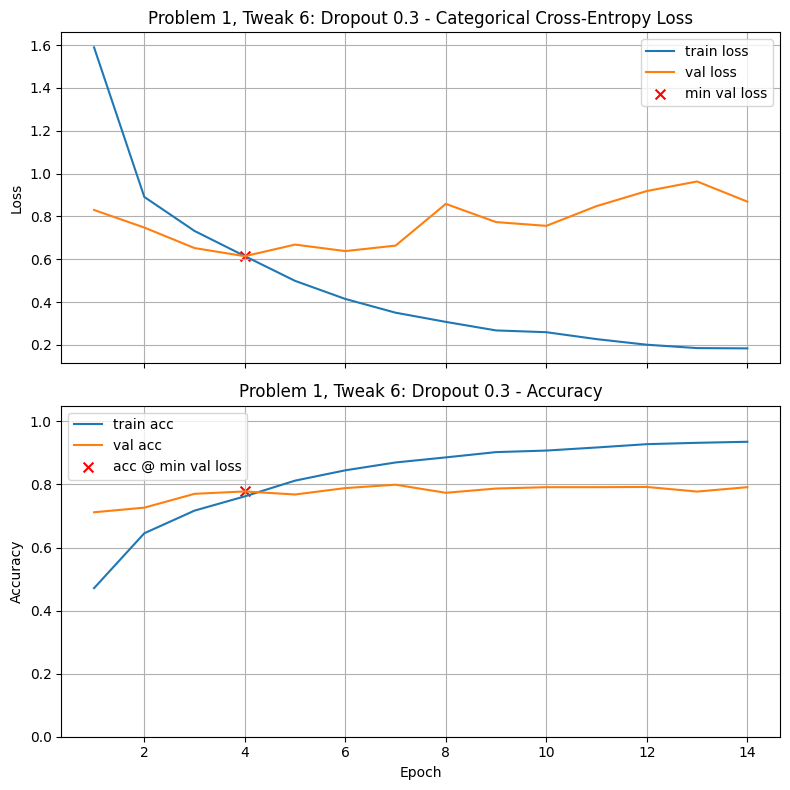

Final Training Loss:            0.1839
Final Training Accuracy:        0.9354
Final Validation Loss:          0.8693
Final Validation Accuracy:      0.7914
Minimum Validation Loss:        0.6144 (Epoch 4)
Validation Accuracy @ Min Loss: 0.7778

Test Loss: 0.6547
Test Accuracy: 0.7687

Validation-Test Gap (accuracy): 0.009151

Execution Time: 00:01:46


In [11]:
#tweak 6: change dropout rate
he = initializers.HeNormal()                                # best initializer for relu
new_dp = 0.3 #might help if there's underfitting
#build model
base_dp = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(new_dp),
    Dense(num_classes, activation="softmax")
])
#train and test
train_and_test(base_dp, title="Problem 1, Tweak 6: Dropout 0.3")

In [12]:
print_results() #displays results and find best performing

Baseline Model                          	0.7921	7
Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128	0.7850	14
Problem 1, Tweak 6: Dropout 0.3         	0.7778	4
Problem 1, Tweak 1: lr: 1e-4            	0.7414	45


In [13]:
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best validation accuracy:", best_acc)

Best validation accuracy: 0.7920827269554138


### Graded Questions

In [14]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [15]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 2


**UPDATE TO NEW NUMBER**

In [51]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.7850             # Replace 0.0 with your answer

In [52]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7850


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Problem 2: Baseline with adjusted dropout and BatchNorm (lr=1e-4)



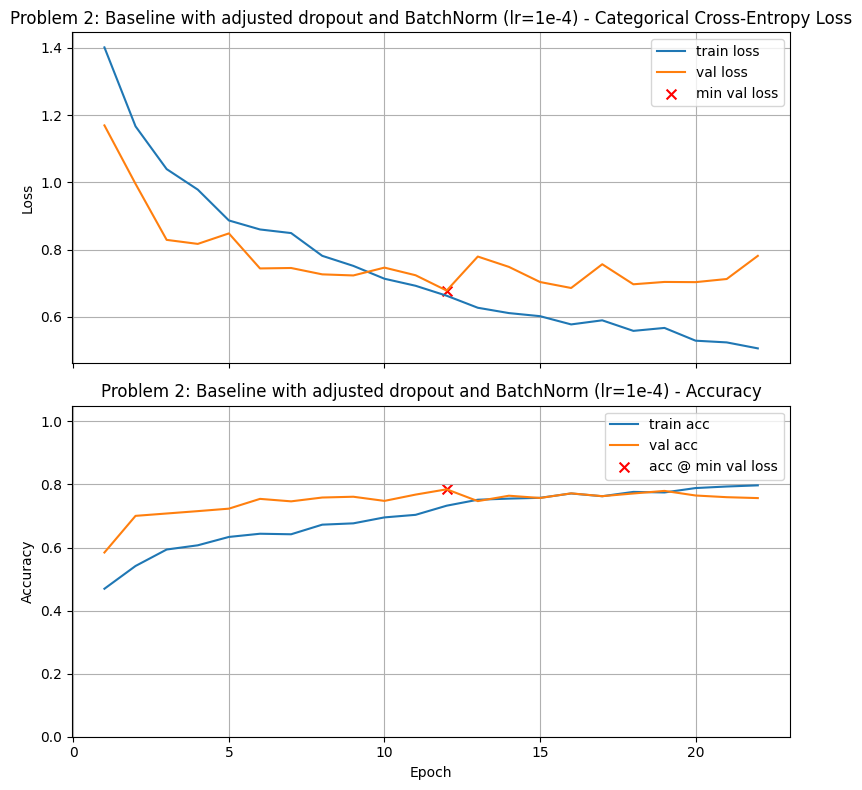

Final Training Loss:            0.5065
Final Training Accuracy:        0.7972
Final Validation Loss:          0.7817
Final Validation Accuracy:      0.7568
Minimum Validation Loss:        0.6784 (Epoch 12)
Validation Accuracy @ Min Loss: 0.7846

Test Loss: 0.7365
Test Accuracy: 0.7580

Validation-Test Gap (accuracy): 0.026593

Execution Time: 00:03:19


In [18]:
# Your code here, add additional cells if you wish

#model from 1: Problem 1, Tweak 6: Dropout 0.3
he = initializers.HeNormal()                                # best initializer for relu

#after i ran this, my accuracy was very low and the model did not seem to be learning
#to fix this, I am going to try lowering the learning rate
#build model
base_bn = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), padding="same", kernel_initializer=he),
    BatchNormalization(),
    layers.Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), padding="same", kernel_initializer=he),
    BatchNormalization(),
    layers.Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(new_dp),
    Dense(num_classes, activation="softmax")
])
#train and test
train_and_test(base_bn, lr_schedule=1e-4, title="Problem 2: Baseline with adjusted dropout and BatchNorm (lr=1e-4)")



Problem 2: BatchNorm, w/tweak 2 (64->128), Dropout=0.3 (lr=1e-4)



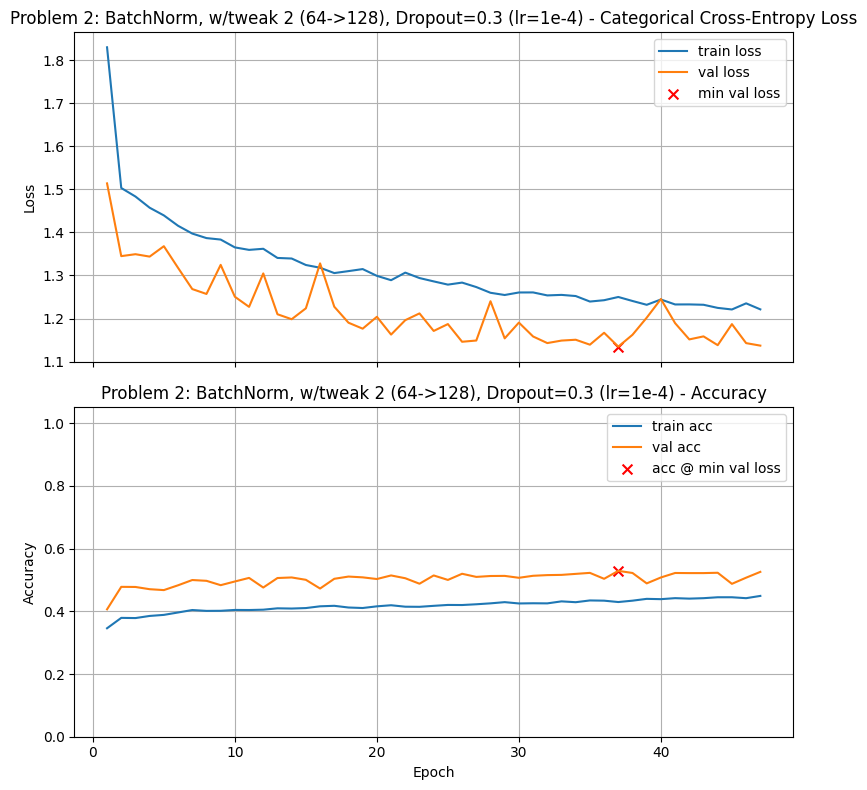

Final Training Loss:            1.2213
Final Training Accuracy:        0.4490
Final Validation Loss:          1.1371
Final Validation Accuracy:      0.5257
Minimum Validation Loss:        1.1347 (Epoch 37)
Validation Accuracy @ Min Loss: 0.5289

Test Loss: 1.1893
Test Accuracy: 0.5003

Validation-Test Gap (accuracy): 0.028554

Execution Time: 00:09:54


In [19]:
#best model from problem 1: batch norm. w/ wider conv (like in tweak 2, problem 1)
#again, using lower lr since results w/ original lr were not showing learning
base_bn_wide = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), padding="same", kernel_initializer=he),
    BatchNormalization(),
    layers.Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), padding="same", kernel_initializer=he),
    BatchNormalization(),
    layers.Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(base_bn_wide, lr_schedule=1e-4, title="Problem 2: BatchNorm, w/tweak 2 (64->128), Dropout=0.3 (lr=1e-4)")


### Graded Questions

In [20]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 6             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 6


In [53]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.7846             # Replace 0.0 with your answer

In [54]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7846


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Problem 3: Baseline



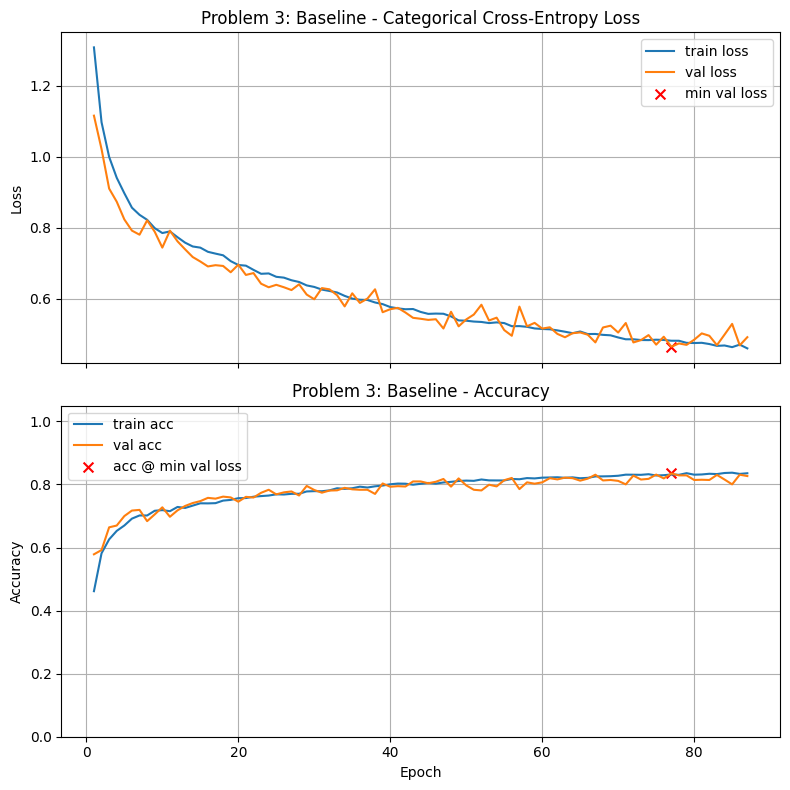

Final Training Loss:            0.4599
Final Training Accuracy:        0.8355
Final Validation Loss:          0.4915
Final Validation Accuracy:      0.8267
Minimum Validation Loss:        0.4645 (Epoch 77)
Validation Accuracy @ Min Loss: 0.8349

Test Loss: 0.5006
Test Accuracy: 0.8240

Validation-Test Gap (accuracy): 0.010879

Execution Time: 00:09:51


In [24]:
# Your code here, add additional cells if you wish
#in problem 2, i saw that the val. accuracy was actually lower when using
#batch normalization, so i will be choosing to omit it in this part and start
#with my problem 1 model as the base

#build model; one of my best models was w/dropout=0.3, but using GlobalAveragePooling2D
#eliminates gap, so just using baseline model here
base_gap = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])
#train and test
train_and_test(base_gap, title="Problem 3: Baseline")




Problem 3: GAP w/ tweak 2 (64->128)



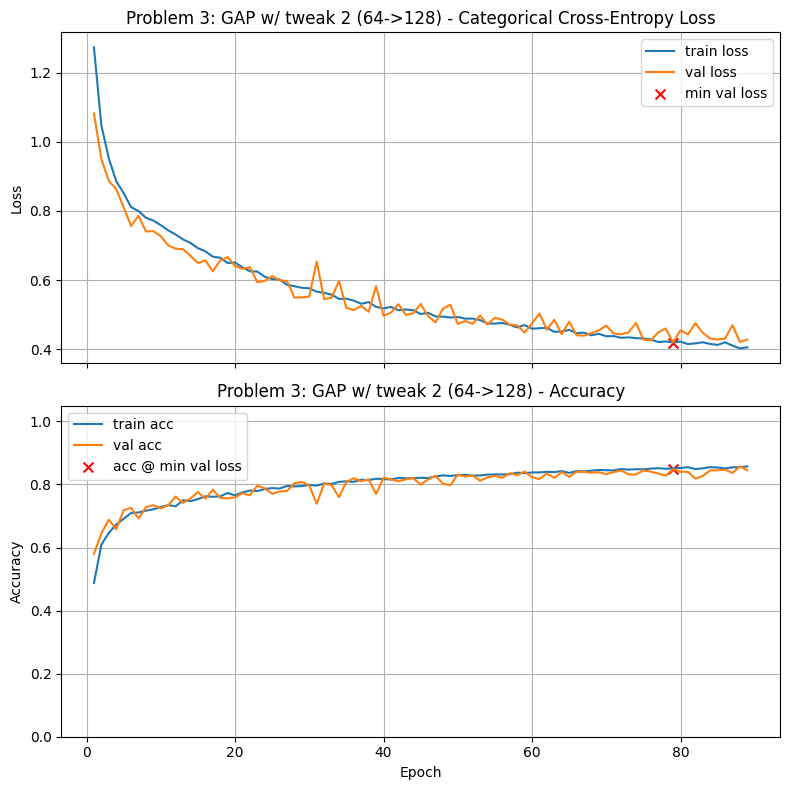

Final Training Loss:            0.4061
Final Training Accuracy:        0.8573
Final Validation Loss:          0.4287
Final Validation Accuracy:      0.8449
Minimum Validation Loss:        0.4198 (Epoch 79)
Validation Accuracy @ Min Loss: 0.8484

Test Loss: 0.4455
Test Accuracy: 0.8447

Validation-Test Gap (accuracy): 0.003764

Execution Time: 00:14:21


In [25]:
#test w/ best model: tweak 2: wider conv (64->128)
base_gap_wide = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])
#train and test
train_and_test(base_gap_wide, title="Problem 3: GAP w/ tweak 2 (64->128)")

In [26]:
print_results()

Problem 3: GAP w/ tweak 2 (64->128)     	0.8484	79
Problem 3: Baseline                     	0.8349	77
Baseline Model                          	0.7921	7
Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128	0.7850	14
Problem 2: Baseline with adjusted dropout and BatchNorm (lr=1e-4)	0.7846	12
Problem 1, Tweak 6: Dropout 0.3         	0.7778	4
Problem 1, Tweak 1: lr: 1e-4            	0.7414	45
Problem 2: BatchNorm, w/tweak 2 (64->128), Dropout=0.3 (lr=1e-4)	0.5289	37


### Graded Questions

In [27]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 2             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [28]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 2


In [55]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8484             # Replace 0.0 with your answer

In [56]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8484


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.




Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.5)



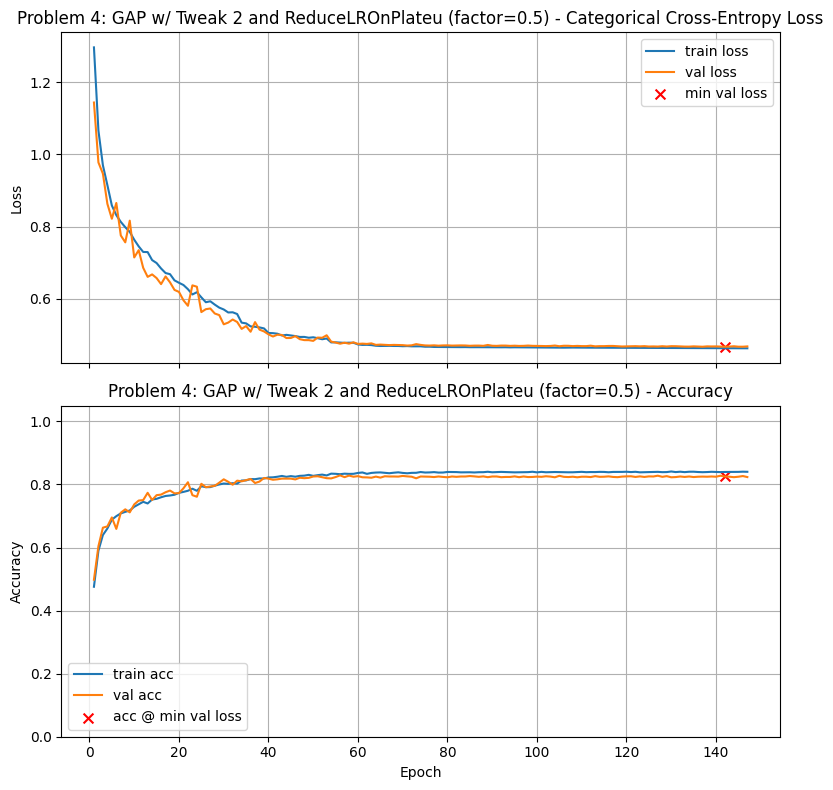

Final Training Loss:            0.4631
Final Training Accuracy:        0.8402
Final Validation Loss:          0.4683
Final Validation Accuracy:      0.8235
Minimum Validation Loss:        0.4674 (Epoch 142)
Validation Accuracy @ Min Loss: 0.8252

Test Loss: 0.4940
Test Accuracy: 0.8260

Validation-Test Gap (accuracy): 0.001107

Execution Time: 00:23:43


In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

#my best model so far has been the one from problem 3 using GAP and a wider conv (tweak 2)
#rebuilding that model:
def build_best_gap_mod():
  model = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
  ])
  return model

base_rlr = build_best_gap_mod()
#train and test w/ ReduceLRonPlateau w/ factor = 0.5
train_and_test(base_rlr, callbacks=[reduce_lr], title="Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.5)")



Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.3)


Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 36: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 52: ReduceLROnPlateau reducing learning rate to 1e-05.


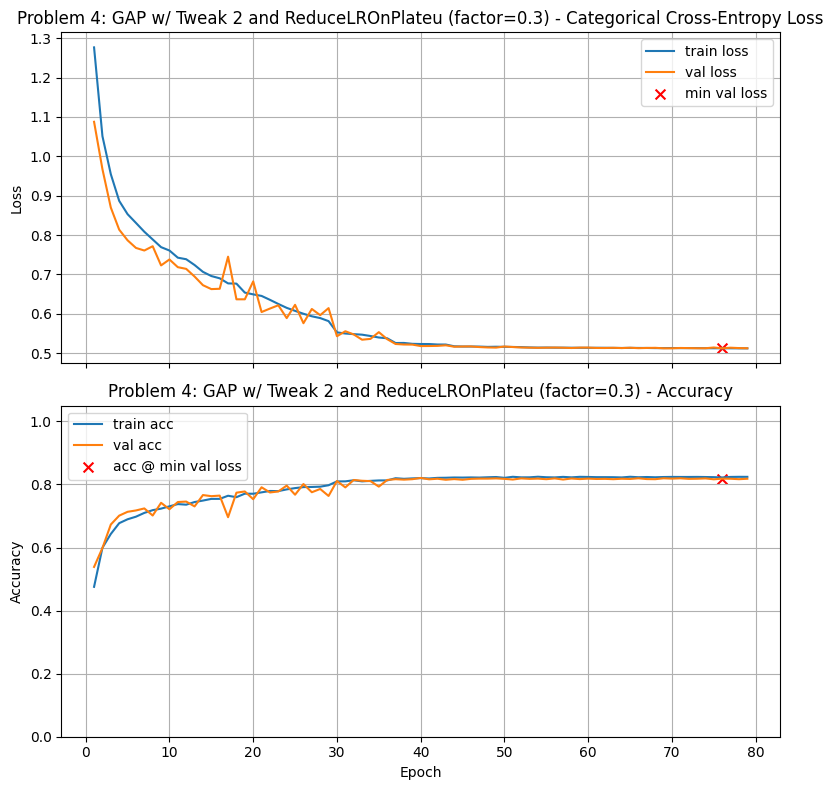

Final Training Loss:            0.5121
Final Training Accuracy:        0.8241
Final Validation Loss:          0.5125
Final Validation Accuracy:      0.8181
Minimum Validation Loss:        0.5123 (Epoch 76)
Validation Accuracy @ Min Loss: 0.8185

Test Loss: 0.5356
Test Accuracy: 0.8117

Validation-Test Gap (accuracy): 0.007877

Execution Time: 00:12:46


In [32]:
#test w factor=0.3
reduce_lr_03 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_rlr_03 = build_best_gap_mod()

train_and_test(
    model_rlr_03,
    callbacks=[reduce_lr_03],
    title="Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.3)"
)


In [33]:
print_results()

Problem 3: GAP w/ tweak 2 (64->128)     	0.8484	79
Problem 3: Baseline                     	0.8349	77
Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.5)	0.8252	142
Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.3)	0.8185	76
Baseline Model                          	0.7921	7
Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128	0.7850	14
Problem 2: Baseline with adjusted dropout and BatchNorm (lr=1e-4)	0.7846	12
Problem 1, Tweak 6: Dropout 0.3         	0.7778	4
Problem 1, Tweak 1: lr: 1e-4            	0.7414	45
Problem 2: BatchNorm, w/tweak 2 (64->128), Dropout=0.3 (lr=1e-4)	0.5289	37


### Graded Questions

In [34]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.5             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [35]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.50


In [57]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.8252             # Replace 0.0 with your answer

In [58]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8252


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see [Explanation of VGG-16](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/) :
        

![Screenshot 2025-09-19 at 6.50.24 AM.png](attachment:62fa0824-bb06-4663-a6a5-da8cca8f4ab3.png)


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.




VGG-style Large



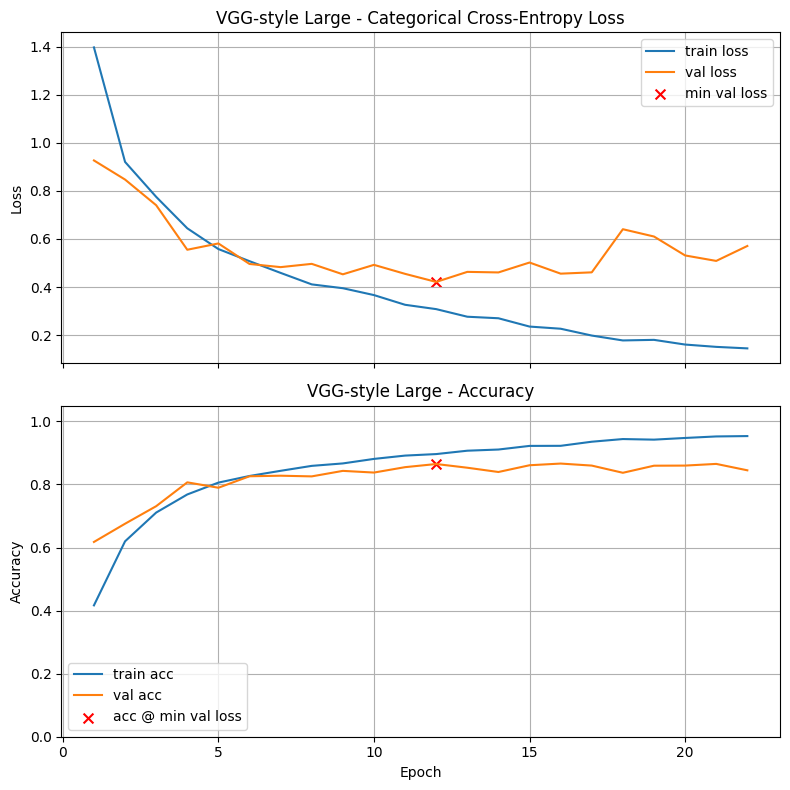

Final Training Loss:            0.1446
Final Training Accuracy:        0.9534
Final Validation Loss:          0.5708
Final Validation Accuracy:      0.8449
Minimum Validation Loss:        0.4212 (Epoch 12)
Validation Accuracy @ Min Loss: 0.8648

Test Loss: 0.4332
Test Accuracy: 0.8623

Validation-Test Gap (accuracy): 0.002503

Execution Time: 00:33:38


In [38]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")


Problem 5: VGG-style, lr: 0.01



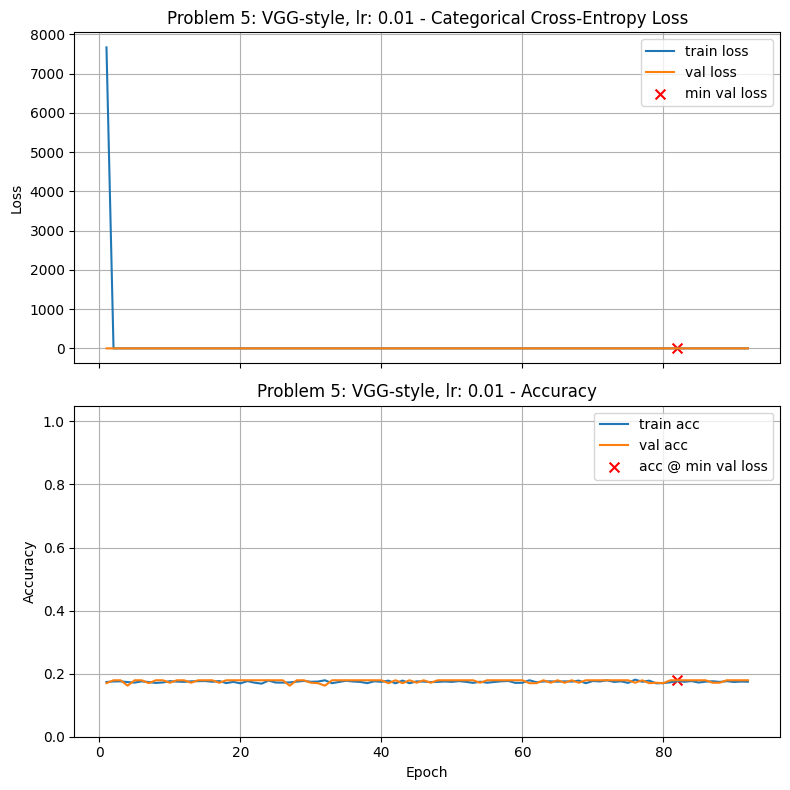

Final Training Loss:            1.7918
Final Training Accuracy:        0.1744
Final Validation Loss:          1.7914
Final Validation Accuracy:      0.1790
Minimum Validation Loss:        1.7909 (Epoch 82)
Validation Accuracy @ Min Loss: 0.1790

Test Loss: 1.7900
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004030

Execution Time: 02:06:34

Problem 5: VGG-style, lr: 0.003



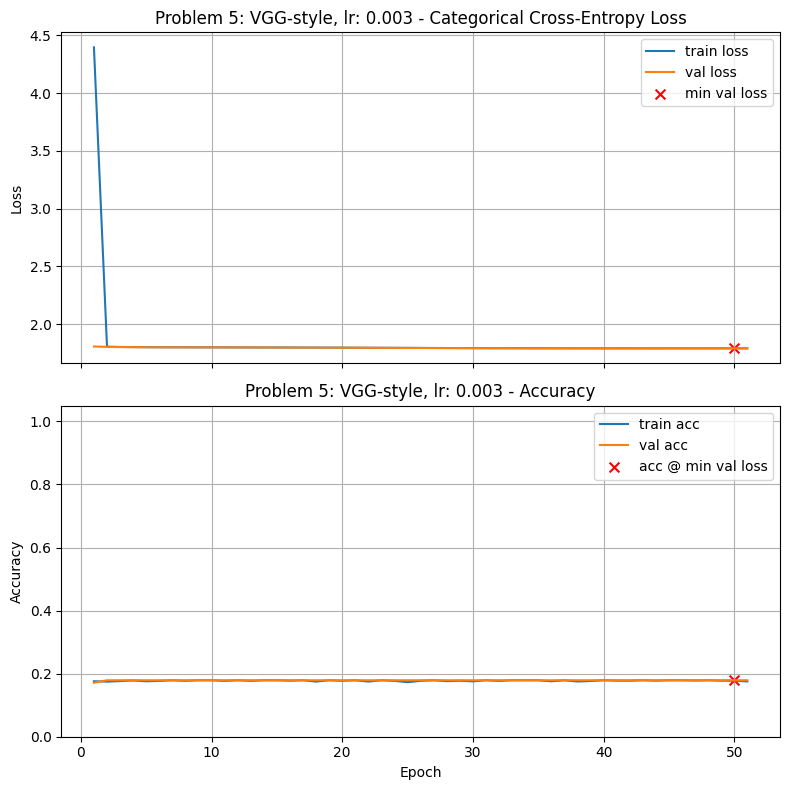

Final Training Loss:            1.7911
Final Training Accuracy:        0.1754
Final Validation Loss:          1.7908
Final Validation Accuracy:      0.1790
Minimum Validation Loss:        1.7908 (Epoch 50)
Validation Accuracy @ Min Loss: 0.1790

Test Loss: 1.7905
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004030

Execution Time: 01:12:07

Problem 5: VGG-style, lr: 0.001



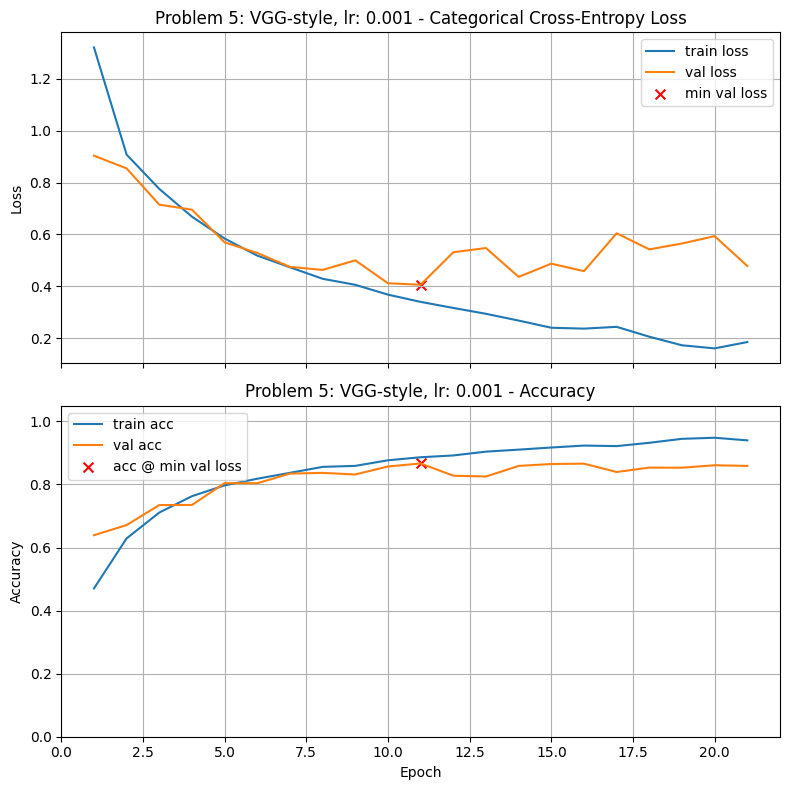

Final Training Loss:            0.1849
Final Training Accuracy:        0.9398
Final Validation Loss:          0.4781
Final Validation Accuracy:      0.8588
Minimum Validation Loss:        0.4057 (Epoch 11)
Validation Accuracy @ Min Loss: 0.8666

Test Loss: 0.4228
Test Accuracy: 0.8547

Validation-Test Gap (accuracy): 0.011952

Execution Time: 00:31:07

Problem 5: VGG-style, lr: 0.0003



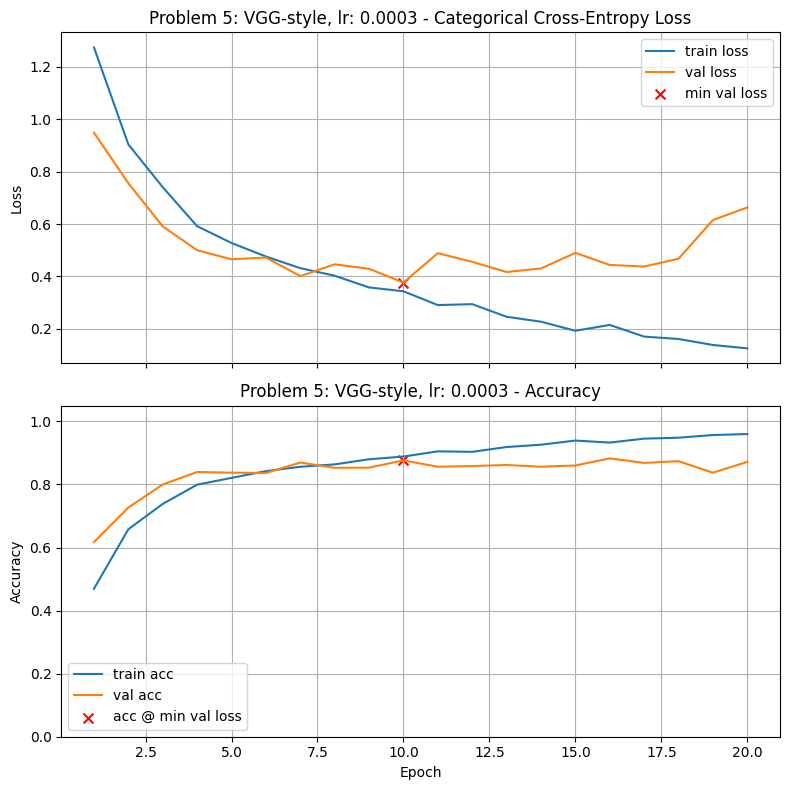

Final Training Loss:            0.1257
Final Training Accuracy:        0.9599
Final Validation Loss:          0.6633
Final Validation Accuracy:      0.8716
Minimum Validation Loss:        0.3766 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8762

Test Loss: 0.3939
Test Accuracy: 0.8653

Validation-Test Gap (accuracy): 0.010915

Execution Time: 00:30:38

Problem 5: VGG-style, lr: 0.0001



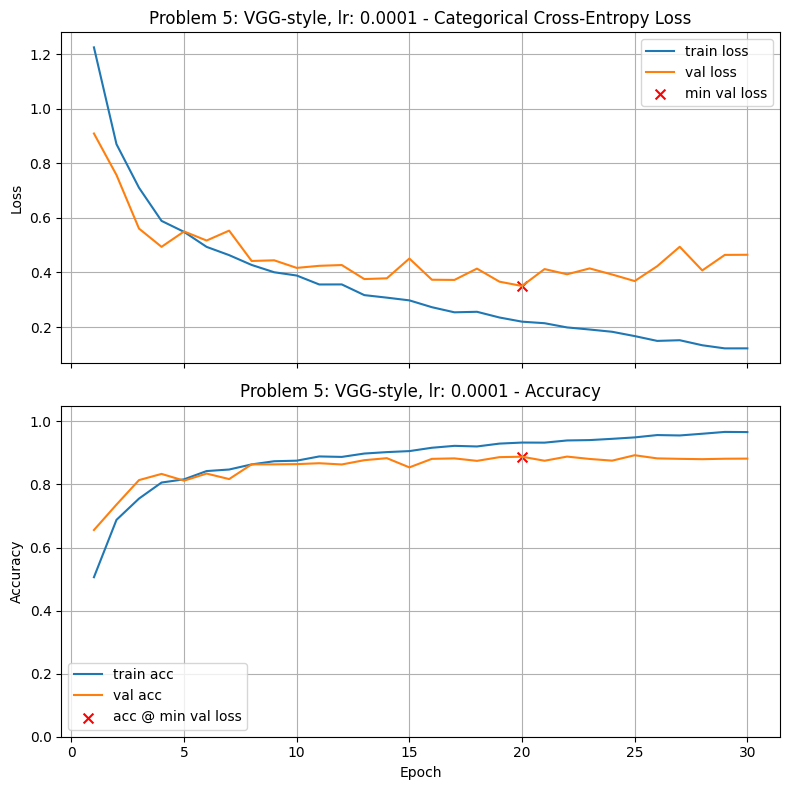

Final Training Loss:            0.1218
Final Training Accuracy:        0.9661
Final Validation Loss:          0.4647
Final Validation Accuracy:      0.8820
Minimum Validation Loss:        0.3504 (Epoch 20)
Validation Accuracy @ Min Loss: 0.8880

Test Loss: 0.3504
Test Accuracy: 0.8897

Validation-Test Gap (accuracy): 0.001650

Execution Time: 00:47:07

Problem 5: VGG-style, lr: 3e-05



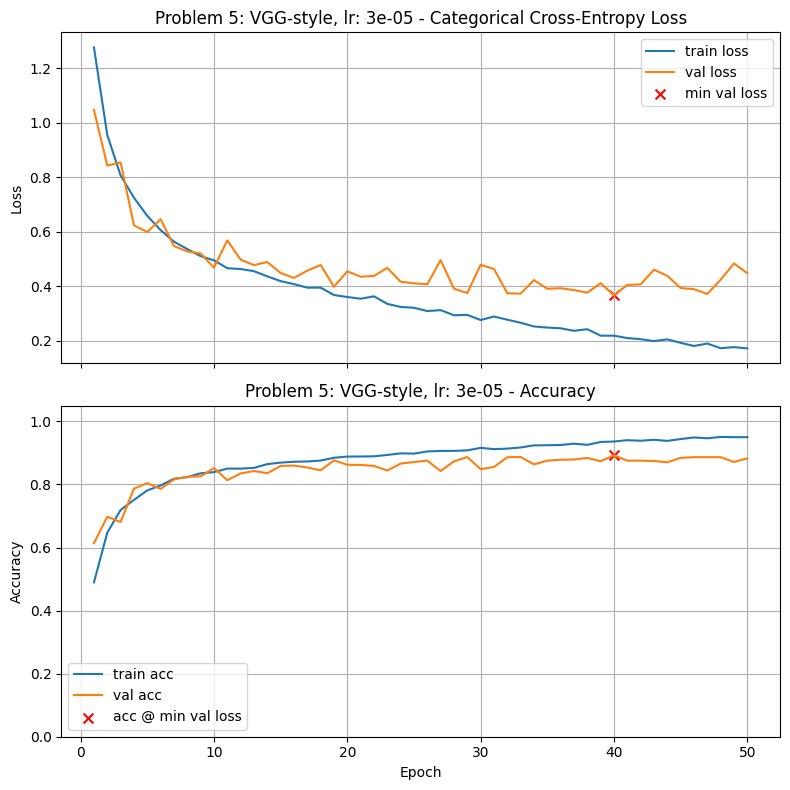

Final Training Loss:            0.1711
Final Training Accuracy:        0.9500
Final Validation Loss:          0.4473
Final Validation Accuracy:      0.8830
Minimum Validation Loss:        0.3662 (Epoch 40)
Validation Accuracy @ Min Loss: 0.8923

Test Loss: 0.3657
Test Accuracy: 0.8920

Validation-Test Gap (accuracy): 0.000297

Execution Time: 01:18:28

Problem 5: VGG-style, lr: 1e-05



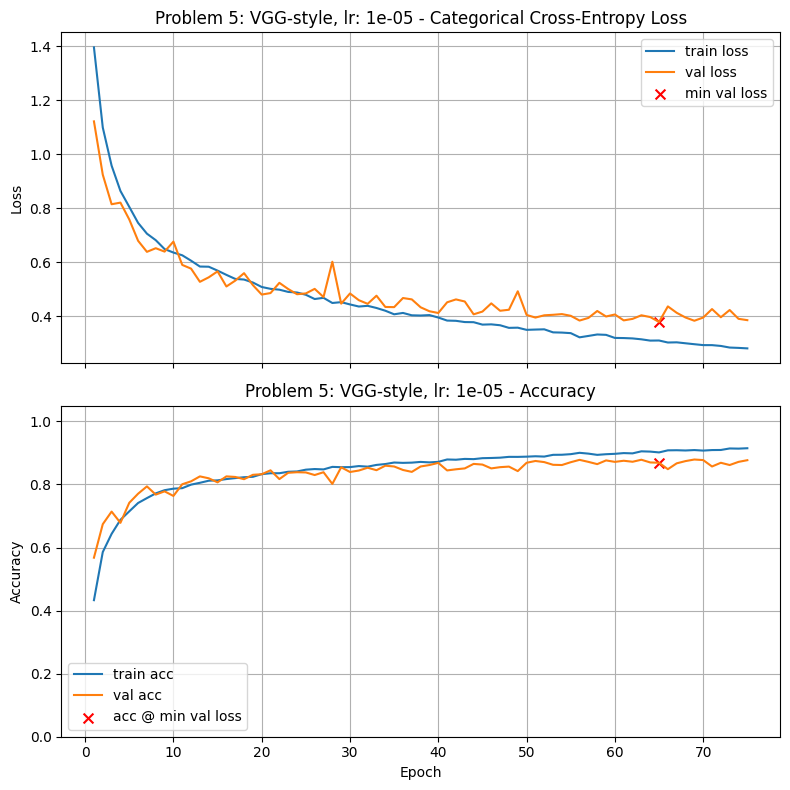

Final Training Loss:            0.2815
Final Training Accuracy:        0.9149
Final Validation Loss:          0.3860
Final Validation Accuracy:      0.8770
Minimum Validation Loss:        0.3794 (Epoch 65)
Validation Accuracy @ Min Loss: 0.8688

Test Loss: 0.3904
Test Accuracy: 0.8767

Validation-Test Gap (accuracy): 0.007908

Execution Time: 01:58:21


In [39]:
#since keras reuses weights if you train the same model mult. times
#for each learning rate recreate model (by wrapping in a func)
def build_vgg_16():
  model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),

        # Block 1
        layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.MaxPooling2D(),

        # Block 4 (NO MaxPool here)
        layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu', kernel_initializer=he,
                     kernel_regularizer=l2reg),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
  return model
#run through LR sweep
lrs = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for lr in lrs:
  model_vgg = build_vgg_16()
  train_and_test(
      model_vgg,
      lr_schedule=lr,
      title=f"Problem 5: VGG-style, lr: {lr}"
  )

In [45]:
print_results()

Problem 5: VGG-style, lr: 3e-05         	0.8923	40
Problem 5: VGG-style, lr: 0.0001        	0.8880	20
Problem 5: VGG-style, lr: 0.0003        	0.8762	10
Problem 5: VGG-style, lr: 1e-05         	0.8688	65
Problem 5: VGG-style, lr: 0.001         	0.8666	11
VGG-style Large                         	0.8648	12
Problem 3: GAP w/ tweak 2 (64->128)     	0.8484	79
Problem 3: Baseline                     	0.8349	77
Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.5)	0.8252	142
Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.3)	0.8185	76
Baseline Model                          	0.7921	7
Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128	0.7850	14
Problem 2: Baseline with adjusted dropout and BatchNorm (lr=1e-4)	0.7846	12
Problem 1, Tweak 6: Dropout 0.3         	0.7778	4
Problem 1, Tweak 1: lr: 1e-4            	0.7414	45
Problem 2: BatchNorm, w/tweak 2 (64->128), Dropout=0.3 (lr=1e-4)	0.5289	37
Problem 5: VGG-style, lr: 0.01          	0.1790	82
Problem 5: VGG-style, lr: 0.003 

### Graded Questions

In [46]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 3e-5             # Replace with your best learning rate

In [47]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00003000


In [48]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.8923              # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8923


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [50]:
print_results()

Problem 5: VGG-style, lr: 3e-05         	0.8923	40
Problem 5: VGG-style, lr: 0.0001        	0.8880	20
Problem 5: VGG-style, lr: 0.0003        	0.8762	10
Problem 5: VGG-style, lr: 1e-05         	0.8688	65
Problem 5: VGG-style, lr: 0.001         	0.8666	11
VGG-style Large                         	0.8648	12
Problem 3: GAP w/ tweak 2 (64->128)     	0.8484	79
Problem 3: Baseline                     	0.8349	77
Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.5)	0.8252	142
Problem 4: GAP w/ Tweak 2 and ReduceLROnPlateu (factor=0.3)	0.8185	76
Baseline Model                          	0.7921	7
Problem 1, Tweak 2: Change Conv2D layer width 64 -> 128	0.7850	14
Problem 2: Baseline with adjusted dropout and BatchNorm (lr=1e-4)	0.7846	12
Problem 1, Tweak 6: Dropout 0.3         	0.7778	4
Problem 1, Tweak 1: lr: 1e-4            	0.7414	45
Problem 2: BatchNorm, w/tweak 2 (64->128), Dropout=0.3 (lr=1e-4)	0.5289	37
Problem 5: VGG-style, lr: 0.01          	0.1790	82
Problem 5: VGG-style, lr: 0.003 

    VGG-style Large -- lr: 0.0001           	0.8700	18
    Model with ReduceLROnPlateau            	0.8636	227
    VGG-style Large -- lr: 0.0003           	0.8400	23
    VGG-style Large -- lr: 1e-05            	0.8301	60
    VGG-style Large -- lr: 3e-05            	0.8269	26
    Baseline model using BatchNormalization -- Tweak 2 -- 64 -> 128	0.8140	33
    Baseline Plus -- Tweaks 5 & 6 -- Do: 0.3	0.8030	50
    Baseline model using BatchNormalization -- Tweak 3 -- 32 -> 64 -> 128	0.8019	26
    Baseline model using BatchNormalization -- Tweak 4 -- Dense 128	0.7976	24
    Baseline model using BatchNormalization 	0.7941	7
    Baseline Plus -- Tweak 3 -- 32 -> 64 -> 128	0.7912	20
    Baseline Plus -- Tweak 6 -- Do: 0.3     	0.7745	36
    Baseline Plus -- Tweak 2 -- 64 -> 128   	0.7645	25
    Baseline Plus -- Tweak 5 -- L2: 1e-4    	0.7570	27
    Model using GAP                         	0.7553	10
    Baseline Plus -- Two Tweaks! -- L2: 1e-4 Do: 0.3	0.7506	19
    VGG-style Large -- lr: 0.001            	0.6865	5
    Baseline Plus -- Tweak 4 -- Dense 128   	0.5999	1
    Baseline Plus -- Tweak 1 -- lr: 1e-4    	0.4817	3
    Baseline model using BatchNormalization -- Tweak 1 lr: 0.0001 	0.3691	1
    VGG-style Large -- lr: 0.01             	0.1792	95
    VGG-style Large -- lr: 0.003            	0.1792	195
    Baseline Model                          	0.0000	1